In [26]:
##эти библиотеки необходимы для использования набора функций
import pandas as pd
import numpy as np

##а вот эта библиотека нужна для запуска вспомогательного кода
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

### Определение функций для подсчёта сейсмических индикаторов из работы Adeli & Panakkat

##### Вспомогательные функции 
(для использования в скользящем окне)

In [27]:
##подсчёт b-value с помощью метода наименьших квадратов
def bvalue_OLS(magnitude_series):
    magnitudes = magnitude_series.value_counts().sort_index()
    
    M = magnitudes.index.tolist()
    values = magnitudes.tolist()
    N = np.cumsum(values[::-1])[::-1]
    logN = np.log10(N)
    b,a = np.polyfit(M, logN, 1)
    return b*(-1)

##подсчёт среднего отклонения от "предсказания", данного методом наименьших квадратов
def mean_deviation_OLS(magnitude_series):
    magnitudes = magnitude_series.value_counts().sort_index()
    
    M = magnitudes.index.tolist()
    values = magnitudes.tolist()
    N = np.cumsum(values[::-1])[::-1]
    logN = np.log10(N)
    b,a = np.polyfit(M, logN, 1)
    b *= (-1)
    nu = 0
    for i in range (len(M)):
        nu += 1/(len(M)-1)*np.power(logN[i]-(a - (b * M[i])),2.0)
    return nu

##подсчёт a-value с помощью метода наименьших квадратов
def avalue_OLS(magnitude_series):
    magnitudes = magnitude_series.value_counts().sort_index()
    
    M = magnitudes.index.tolist()
    values = magnitudes.tolist()
    N = np.cumsum(values[::-1])[::-1]
    logN = np.log10(N)
    b,a = np.polyfit(M, logN, 1)
    return a

##### Функции, непосредственно преобразовывающие набор данных о землетрясениях 

In [28]:
##На вход функциям подаются данные о землетрясениях (Pandas Dataframe), содержащие время, место и магнитуду событий
#Функции используются для извлечения признаков

###ОЧЕНЬ ВАЖНО: функции оперируют столбцами Dataframe, имеющими конкретные названия.
##Они не будут работать корректно, если во входных данных не будет колонки со временем, названной 'time',
##и колонки с магнитудой, названной 'mag'. Пожалуйста, переименуйте соответствующие столбцы в своих данных!

##Извлечение непараметрических признаков (тех, что не зависят от характеристического распределения и закона Гутенберга-Рихтера)
#Параметры: earthquake_dataset (pd.DataFrame с данными о землетрясениях), 
########### time_window (число событий, используемых при подсчёте индикаторов)

def generate_nonparam_features(earthquake_dataset, time_window):
    
    earthquake_dataset['Elapsed time between last N events'] = (earthquake_dataset['time'].shift(1)-earthquake_dataset['time'].shift(time_window+1))
    earthquake_dataset['Elapsed days'] = earthquake_dataset['Elapsed time between last N events'].dt.days
    
    earthquake_dataset['Mean magnitude'] = earthquake_dataset['mag'].rolling(time_window).mean().shift(1)
    
    earthquake_dataset['Square root of energy'] = np.sqrt(np.power(10.0, (11.8 + (1.5*earthquake_dataset['mag']))))
    earthquake_dataset['Rate of square root of energy released'] = earthquake_dataset['Square root of energy'].rolling(time_window).sum().shift(1)
    earthquake_dataset['Rate of square root of energy released'] = earthquake_dataset['Rate of square root of energy released']/earthquake_dataset['Elapsed days']
    
    earthquake_dataset = earthquake_dataset.drop(columns = ["Elapsed time between last N events","Square root of energy"])
    return earthquake_dataset

##Извлечение признаков, основанных на законе Гутенберга-Рихтера (b-value получено методом наименьших квадратов)
#Параметры: earthquake_dataset (pd.DataFrame с данными о землетрясениях), 
########### time_window (число событий, используемых при подсчёте индикаторов)

def generate_GR_Adeli_Panakkat_features(earthquake_dataset, time_window):
    earthquake_dataset['b-value'] = earthquake_dataset['mag'].rolling(time_window).apply(func=bvalue_OLS,raw = False).shift(1)
    earthquake_dataset['Mean square deviation'] = earthquake_dataset['mag'].rolling(time_window).apply(func=mean_deviation_OLS,raw = False).shift(1)
    earthquake_dataset['a-value'] = earthquake_dataset['mag'].rolling(time_window).apply(func=avalue_OLS,raw = False).shift(1)
    earthquake_dataset['Max magnitude expected'] = earthquake_dataset['a-value']/earthquake_dataset['b-value']
    earthquake_dataset['Max magnitude observed'] = earthquake_dataset['mag'].rolling(time_window).max().shift(1)
    earthquake_dataset['Magnitude deficit'] = earthquake_dataset['Max magnitude observed'] - earthquake_dataset['Max magnitude expected']
    earthquake_dataset = earthquake_dataset.drop(columns = ["a-value","Max magnitude expected", "Max magnitude observed"])
    return earthquake_dataset

##Извлечение признаков, основанных на характеристической модели распределения магнитуд
#Параметры: earthquake_dataset (pd.DataFrame с данными о землетрясениях), 
########### time_window (число событий, используемых при подсчёте индикаторов),
########### lower_bound, upper_bound (верхняя и нижняя граница диапазона характеристических магнитуд, выбирается вручную для каталога)

def generate_characteristic_features(earthquake_dataset, time_window, lower_bound, upper_bound):
    earthquake_dataset['Mean time between characteristic events'] = np.nan
    earthquake_dataset['Coefficient of variation from mean time'] = np.nan
    for i in range (time_window, len(earthquake_dataset)):
        char_events = earthquake_dataset.iloc[i-time_window:i].copy(deep=True)
        char_events = char_events[char_events['mag'] >= lower_bound]
        char_events = char_events[char_events['mag'] <= upper_bound].sort_values(by='time',ascending=True).reset_index(drop = True)
        char_events['Time between this event and the previous one'] = (char_events['time']-char_events['time'].shift(1)).dt.days
        char_std = char_events['Time between this event and the previous one'].std()
        mean_time_char = char_events['Time between this event and the previous one'].mean()
        earthquake_dataset['Mean time between characteristic events'].iloc[i] = mean_time_char 
        earthquake_dataset['Coefficient of variation from mean time'].iloc[i] = mean_time_char/char_std
        print(i/len(earthquake_dataset)*100,'%') ##закомментируйте эту строчку, если не хотите видеть прогресс. 
        ##предупреждение: для этой функции пришлось написать цикл, и он может работать довольно долго :( 
    return earthquake_dataset

### Пример обработки данных и вычисления индикаторов Adeli & Panakkat

В качестве примера рассмотрим вычисление сейсмических индикаторов для небольшого набора данных о землетрясениях в Центральной Японии (данные взяты из каталога USGS)

In [29]:
#импорт "сырого" csv
japan_raw = pd.read_csv(r'C:\Users\Alyona\Desktop\DATASETS\japan 20 yrs.csv')

japan_raw.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1999-01-01T15:46:03.470Z,36.174,141.659,33.0,4.5,mb,NaN,NaN,NaN,1.09,...,2014-11-07T01:06:45.387Z,"near the east coast of Honshu, Japan",earthquake,NaN,NaN,NaN,13.0,reviewed,us,us
1,1999-01-01T16:20:30.940Z,36.139,141.636,33.0,5.3,mwc,NaN,NaN,NaN,0.82,...,2016-11-09T21:34:52.940Z,"near the east coast of Honshu, Japan",earthquake,NaN,NaN,NaN,NaN,reviewed,us,hrv
2,1999-01-01T16:43:01.120Z,36.181,141.738,33.0,4.5,mb,NaN,NaN,NaN,1.23,...,2014-11-07T01:06:45.484Z,"near the east coast of Honshu, Japan",earthquake,NaN,NaN,NaN,5.0,reviewed,us,us
3,1999-01-01T18:30:30.250Z,36.208,141.685,33.0,4.5,mb,NaN,NaN,NaN,1.31,...,2014-11-07T01:06:45.551Z,"near the east coast of Honshu, Japan",earthquake,NaN,NaN,NaN,8.0,reviewed,us,us
4,1999-01-01T22:08:41.770Z,36.155,141.636,33.0,4.7,mb,NaN,NaN,NaN,1.18,...,2014-11-07T01:06:45.605Z,"near the east coast of Honshu, Japan",earthquake,NaN,NaN,NaN,9.0,reviewed,us,us


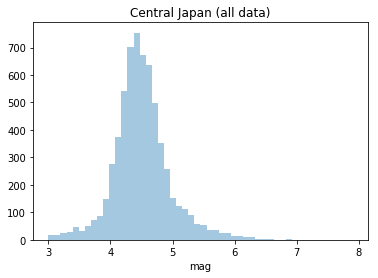

In [30]:
#обработка колонки time
japan_raw['time'] = pd.to_datetime(japan_raw['time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
#график распределения магнитуд
jp = sns.distplot(japan_raw[japan_raw['mag']>0]['mag'], kde = False).set_title("Central Japan (all data)")

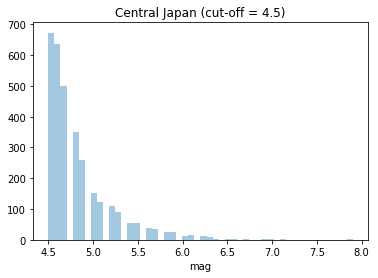

In [31]:
#график распределения при отсечении данных, не соответствующих закону Гутенберга-Рихтера (cut-off magnitude)
jp = sns.distplot(japan_raw[japan_raw['mag']>=4.5]['mag'], kde = False).set_title("Central Japan (cut-off = 4.5)")

In [32]:
##отбрасываем колонки, которые нам не нужны (в теории, этого можно и не делать)
japan_raw=japan_raw.drop(columns = ["id","nst","magType","gap","dmin","rms","net","updated",
                                    "place","type","horizontalError","depthError",
                                    "magError","magNst","status","locationSource","magSource"])
japan_raw.head()

,time,latitude,longitude,depth,mag
0,1999-01-01 15:46:03.470,36.174,141.659,33.0,4.5
1,1999-01-01 16:20:30.940,36.139,141.636,33.0,5.3
2,1999-01-01 16:43:01.120,36.181,141.738,33.0,4.5
3,1999-01-01 18:30:30.250,36.208,141.685,33.0,4.5
4,1999-01-01 22:08:41.770,36.155,141.636,33.0,4.7


In [33]:
##удаляем события, не соответствующие закону Гутенберга-Рихтера (обеспечение полноты каталога)
japan_complete = japan_raw[japan_raw.mag >= 4.5].reset_index(drop = True)

In [34]:
## Генерация сейсмических индикаторов (в данном примере взят размер временного окна, равный 50 событиям, и
## диапазон характеристической магнитуды от 5.0 до 5.5)
japan_complete = generate_GR_Adeli_Panakkat_features(japan_complete, 50)
japan_complete = generate_nonparam_features(japan_complete, 50)
japan_complete = generate_characteristic_features(japan_complete, 50, 5.0, 5.5)


1.5693659761456373 %
1.60075329566855 %
1.6321406151914626 %
1.6635279347143754 %
1.694915254237288 %
1.726302573760201 %
1.7576898932831135 %
1.7890772128060264 %
1.820464532328939 %
1.8518518518518516 %
1.8832391713747645 %
1.9146264908976771 %
1.94601381042059 %
1.977401129943503 %
2.0087884494664157 %
2.0401757689893283 %
2.0715630885122414 %
2.102950408035154 %
2.1343377275580666 %
2.1657250470809792 %
2.197112366603892 %
2.228499686126805 %
2.2598870056497176 %
2.29127432517263 %
2.322661644695543 %
2.354048964218456 %
2.3854362837413685 %
2.416823603264281 %
2.4482109227871938 %
2.4795982423101064 %
2.5109855618330195 %
2.5423728813559325 %
2.573760200878845 %
2.605147520401758 %
2.6365348399246704 %
2.667922159447583 %
2.699309478970496 %
2.7306967984934087 %
2.7620841180163214 %
2.793471437539234 %
2.824858757062147 %
2.8562460765850597 %
2.8876333961079723 %
2.919020715630885 %
2.9504080351537976 %
2.9817953546767106 %
3.0131826741996233 %
3.044569993722536 %
3.07595731324544

14.344005021971123 %
14.375392341494036 %
14.40677966101695 %
14.438166980539863 %
14.469554300062775 %
14.500941619585687 %
14.532328939108599 %
14.563716258631512 %
14.595103578154426 %
14.62649089767734 %
14.65787821720025 %
14.689265536723164 %
14.720652856246078 %
14.752040175768991 %
14.783427495291901 %
14.814814814814813 %
14.846202134337727 %
14.87758945386064 %
14.908976773383554 %
14.940364092906467 %
14.971751412429379 %
15.003138731952292 %
15.034526051475202 %
15.065913370998116 %
15.09730069052103 %
15.128688010043941 %
15.160075329566855 %
15.191462649089768 %
15.222849968612682 %
15.254237288135593 %
15.285624607658507 %
15.317011927181417 %
15.34839924670433 %
15.379786566227244 %
15.411173885750157 %
15.44256120527307 %
15.473948524795983 %
15.505335844318896 %
15.53672316384181 %
15.56811048336472 %
15.599497802887633 %
15.630885122410545 %
15.662272441933458 %
15.693659761456372 %
15.725047080979285 %
15.756434400502197 %
15.78782172002511 %
15.819209039548024 %
15

26.836158192090398 %
26.867545511613304 %
26.898932831136218 %
26.93032015065913 %
26.961707470182045 %
26.99309478970496 %
27.024482109227872 %
27.055869428750785 %
27.087256748273695 %
27.11864406779661 %
27.150031387319522 %
27.181418706842436 %
27.21280602636535 %
27.244193345888263 %
27.275580665411177 %
27.30696798493409 %
27.338355304457 %
27.369742623979914 %
27.401129943502823 %
27.432517263025737 %
27.463904582548647 %
27.49529190207156 %
27.526679221594474 %
27.558066541117388 %
27.5894538606403 %
27.620841180163215 %
27.652228499686128 %
27.683615819209038 %
27.71500313873195 %
27.746390458254865 %
27.77777777777778 %
27.809165097300692 %
27.840552416823606 %
27.87193973634652 %
27.903327055869433 %
27.93471437539234 %
27.966101694915253 %
27.997489014438166 %
28.02887633396108 %
28.06026365348399 %
28.091650973006903 %
28.123038292529817 %
28.15442561205273 %
28.185812931575644 %
28.217200251098557 %
28.24858757062147 %
28.279974890144384 %
28.311362209667294 %
28.34274952

39.485247959824235 %
39.51663527934714 %
39.548022598870055 %
39.57940991839297 %
39.61079723791588 %
39.64218455743879 %
39.6735718769617 %
39.704959196484616 %
39.73634651600753 %
39.76773383553044 %
39.799121155053356 %
39.83050847457627 %
39.86189579409918 %
39.8932831136221 %
39.92467043314501 %
39.956057752667924 %
39.98744507219084 %
40.01883239171375 %
40.050219711236664 %
40.08160703075958 %
40.11299435028249 %
40.1443816698054 %
40.17576898932831 %
40.207156308851225 %
40.23854362837413 %
40.269930947897045 %
40.30131826741996 %
40.33270558694287 %
40.364092906465785 %
40.3954802259887 %
40.42686754551161 %
40.458254865034526 %
40.48964218455744 %
40.52102950408035 %
40.55241682360327 %
40.58380414312618 %
40.61519146264909 %
40.64657878217201 %
40.67796610169492 %
40.70935342121783 %
40.74074074074074 %
40.772128060263654 %
40.80351537978657 %
40.83490269930948 %
40.86629001883239 %
40.8976773383553 %
40.929064657878214 %
40.96045197740113 %
40.99183929692404 %
41.0232266164

52.32266164469554 %
52.35404896421846 %
52.38543628374137 %
52.416823603264284 %
52.4482109227872 %
52.47959824231011 %
52.510985561833024 %
52.54237288135594 %
52.57376020087885 %
52.605147520401765 %
52.63653483992468 %
52.66792215944758 %
52.69930947897049 %
52.730696798493405 %
52.76208411801632 %
52.79347143753923 %
52.824858757062145 %
52.85624607658506 %
52.88763339610797 %
52.91902071563088 %
52.95040803515379 %
52.981795354676706 %
53.01318267419962 %
53.04456999372253 %
53.075957313245446 %
53.10734463276836 %
53.13873195229127 %
53.17011927181419 %
53.2015065913371 %
53.232893910860014 %
53.26428123038293 %
53.29566854990584 %
53.327055869428754 %
53.35844318895167 %
53.38983050847458 %
53.421217827997495 %
53.4526051475204 %
53.483992467043315 %
53.51537978656623 %
53.54676710608914 %
53.578154425612055 %
53.60954174513497 %
53.64092906465788 %
53.672316384180796 %
53.70370370370371 %
53.73509102322661 %
53.76647834274952 %
53.797865662272436 %
53.82925298179535 %
53.860640

65.12868801004394 %
65.16007532956685 %
65.19146264908977 %
65.22284996861268 %
65.2542372881356 %
65.2856246076585 %
65.31701192718143 %
65.34839924670433 %
65.37978656622725 %
65.41117388575016 %
65.44256120527307 %
65.47394852479597 %
65.50533584431889 %
65.5367231638418 %
65.56811048336472 %
65.59949780288763 %
65.63088512241055 %
65.66227244193345 %
65.69365976145637 %
65.72504708097928 %
65.7564344005022 %
65.78782172002511 %
65.81920903954803 %
65.85059635907093 %
65.88198367859384 %
65.91337099811676 %
65.94475831763967 %
65.97614563716259 %
66.0075329566855 %
66.03892027620842 %
66.07030759573132 %
66.10169491525424 %
66.13308223477715 %
66.16446955430007 %
66.19585687382298 %
66.2272441933459 %
66.2586315128688 %
66.29001883239172 %
66.32140615191463 %
66.35279347143754 %
66.38418079096046 %
66.41556811048336 %
66.44695543000628 %
66.47834274952919 %
66.5097300690521 %
66.54111738857502 %
66.57250470809792 %
66.60389202762083 %
66.63527934714375 %
66.66666666666666 %
66.69805

78.27997489014437 %
78.3113622096673 %
78.3427495291902 %
78.37413684871312 %
78.40552416823603 %
78.43691148775895 %
78.46829880728185 %
78.49968612680478 %
78.53107344632768 %
78.56246076585059 %
78.59384808537351 %
78.62523540489642 %
78.65662272441934 %
78.68801004394224 %
78.71939736346516 %
78.75078468298807 %
78.78217200251099 %
78.8135593220339 %
78.84494664155682 %
78.87633396107972 %
78.90772128060264 %
78.93910860012555 %
78.97049591964847 %
79.00188323917138 %
79.03327055869428 %
79.0646578782172 %
79.09604519774011 %
79.12743251726303 %
79.15881983678594 %
79.19020715630886 %
79.22159447583176 %
79.25298179535469 %
79.28436911487758 %
79.3157564344005 %
79.3471437539234 %
79.37853107344633 %
79.40991839296923 %
79.44130571249215 %
79.47269303201506 %
79.50408035153798 %
79.53546767106089 %
79.5668549905838 %
79.59824231010671 %
79.62962962962963 %
79.66101694915254 %
79.69240426867546 %
79.72379158819837 %
79.75517890772127 %
79.7865662272442 %
79.8179535467671 %
79.849340

91.36848713119899 %
91.39987445072191 %
91.43126177024482 %
91.46264908976774 %
91.49403640929064 %
91.52542372881356 %
91.55681104833647 %
91.58819836785939 %
91.6195856873823 %
91.65097300690522 %
91.68236032642812 %
91.71374764595103 %
91.74513496547395 %
91.77652228499686 %
91.80790960451978 %
91.83929692404269 %
91.8706842435656 %
91.90207156308851 %
91.93345888261143 %
91.96484620213434 %
91.99623352165726 %
92.02762084118015 %
92.05900816070307 %
92.09039548022598 %
92.1217827997489 %
92.1531701192718 %
92.18455743879473 %
92.21594475831763 %
92.24733207784055 %
92.27871939736346 %
92.31010671688638 %
92.34149403640929 %
92.37288135593221 %
92.40426867545511 %
92.43565599497802 %
92.46704331450094 %
92.49843063402385 %
92.52981795354677 %
92.56120527306967 %
92.5925925925926 %
92.6239799121155 %
92.65536723163842 %
92.68675455116133 %
92.71814187068425 %
92.74952919020716 %
92.78091650973008 %
92.81230382925298 %
92.8436911487759 %
92.87507846829881 %
92.90646578782173 %
92.9378

In [35]:
japan_complete.tail()

### При желании можно загрузить результат в .csv:
##japan_complete.to_csv('japan_computed.csv',sep='\t',index=False)

,time,latitude,longitude,depth,mag,b-value,Mean square deviation,Magnitude deficit,Elapsed days,Mean magnitude,Rate of square root of energy released,Mean time between characteristic events,Coefficient of variation from mean time
3181,2018-12-24 05:42:42.350,34.2447,141.4172,36.38,4.6,1.277810,0.007787,-0.082027,137.0,4.748,1.248402e+09,27.0,1.125652
3182,2018-12-24 09:13:48.330,34.0320,141.7049,10.00,4.7,1.273985,0.007762,-0.082965,135.0,4.746,1.263771e+09,27.0,1.125652
3183,2018-12-24 23:20:02.810,34.0691,141.5657,10.00,4.7,1.277810,0.007787,-0.082027,135.0,4.748,1.266897e+09,27.0,1.125652
3184,2018-12-25 00:10:30.610,34.0277,141.6252,10.00,5.3,1.284723,0.007959,-0.080145,132.0,4.752,1.301577e+09,27.0,1.125652
3185,2018-12-31 14:10:24.910,37.4747,141.4768,41.28,5.0,1.285629,0.005020,-0.101185,132.0,4.766,1.341427e+09,21.6,0.898986


### Группировка по времени:

Предположим, мы хотим решать задачу предсказания максимальной магнитуды в регионе за месяц. Тогда полученные данные необходимо сгруппировать следующим образом: 
* каждая строка соответствует месяцу;
* атрибуты - значения индикаторов для последних n событий перед месяцем;
* выходное значение - максимальная магнитуда в этот месяц.

Это можно сделать следующим образом:

In [36]:
japan_grouped = japan_complete.set_index('time')
japan_grouped_parameters = japan_grouped[['b-value','Mean square deviation','Magnitude deficit','Elapsed days',
                   'Mean magnitude','Rate of square root of energy released','Mean time between characteristic events',
                  'Coefficient of variation from mean time']].resample('M', 'first')
#вместо 'M' можно писать 'W', '3M', '5D' - в зависимости от того, какой временной промежуток вы рассматриваете :)
japan_grouped_maxmag = japan_grouped['mag'].resample('M','max')
japan_grouped = pd.merge(japan_grouped_parameters, japan_grouped_maxmag, how='outer', left_index=True, right_index=True)
#japan_grouped.to_csv('japan_grouped_by_month.csv',sep='\t',index=True) ##если хотим сохранить результат
japan_grouped.tail()

,b-value,Mean square deviation,Magnitude deficit,Elapsed days,Mean magnitude,Rate of square root of energy released,Mean time between characteristic events,Coefficient of variation from mean time,mag
time,,,,,,,,,
2018-08-31,1.186840,0.004079,0.044182,202.0,4.742,8.665729e+08,25.666667,0.948495,4.7
2018-09-30,1.230225,0.009824,0.130717,160.0,4.710,1.008074e+09,24.200000,0.807025,5.4
2018-10-31,1.204010,0.006922,0.104076,145.0,4.716,1.136234e+09,25.400000,0.823089,5.7
2018-11-30,1.135607,0.007392,0.013379,134.0,4.742,1.321247e+09,20.250000,1.792784,4.8
2018-12-31,1.366442,0.006361,0.021829,134.0,4.716,1.178226e+09,20.250000,1.792784,5.6
